导入相关包

In [103]:
import pandas as pd 
import numpy as np
import csv
import graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

数据预处理，各模型的数据处理大致一样，不同的地方在于返回的类型可能有略微差别

In [96]:
def add_missing_columns(d, columns) :
    missing_col = set(columns) - set(d.columns)
    for col in missing_col :
        d[col] = 0
        
def fix_columns(d, columns):  
    add_missing_columns(d, columns)
    assert(set(columns) - set(d.columns) == set())
    d = d[columns]
    
    return d

def data_process(df, model) :
    df.replace(" ?", pd.NaT, inplace = True)
    if model == 'train' :
        df.replace(" >50K", 1, inplace = True)
        df.replace(" <=50K", 0, inplace = True)
    if model == 'test':
        df.replace(" >50K.", 1, inplace = True)
        df.replace(" <=50K.", 0, inplace = True)
    trans = {'workclass' : df['workclass'].mode()[0], 'occupation' : df['occupation'].mode()[0], 'native-country' : df['native-country'].mode()[0]}
    df.fillna(trans, inplace = True)

    df.drop('fnlwgt', axis = 1, inplace = True)
    df.drop('capital-gain', axis = 1, inplace = True)
    df.drop('capital-loss', axis = 1, inplace = True)
#         print(df)

    df_object_col = [col for col in df.columns if df[col].dtype.name == 'object']
    df_int_col = [col for col in df.columns if df[col].dtype.name != 'object' and col != 'income']
    target = df["income"]
    dataset = pd.concat([df[df_int_col], pd.get_dummies(df[df_object_col])], axis = 1)

    return target, dataset
        

def Adult_data() :

    df_train = pd.read_csv('adult.csv', header = None, names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
    df_test = pd.read_csv('data.test', header = None, skiprows = 1, names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

    train_target, train_dataset = data_process(df_train, 'train')
    test_target, test_dataset = data_process(df_test, 'test')
#         进行独热编码对齐
    test_dataset = fix_columns(test_dataset, train_dataset.columns)
    columns = train_dataset.columns
#         print(df["income"])

    train_target, test_target = np.array(train_target), np.array(test_target)
    train_dataset, test_dataset = np.array(train_dataset), np.array(test_dataset)
        
    return train_dataset, train_target, test_dataset, test_target, columns

train_dataset, train_target, test_dataset, test_target, columns = Adult_data()
print(train_dataset.shape, test_dataset.shape, train_target.shape, test_target.shape)

(32561, 102) (16281, 102) (32561,) (16281,)


GridSearchCV 类可以用来对分类器的指定参数值进行详尽搜索，这里搜索最佳的决策树的深度

In [97]:
# params = {'max_depth' : range(1, 20)}
# best_clf = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy', random_state = 20), param_grid = params)
# best_clf = best_clf.fit(train_dataset, train_target)
# print(best_clf.best_params_)

{'max_depth': 8}


用决策数进行分类，采用‘熵’作为决策基准，决策深度由上步骤得到8，分裂一个节点所需的样本数至少设为5，并保存预测结果。

In [106]:
# clf = DecisionTreeClassifier() score:0.7836742214851667
classes = [' <=50K', ' >50K']
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, min_samples_split = 5)
clf = clf.fit(train_dataset, train_target)
pred = clf.predict(test_dataset)
print(pred)
score = clf.score(test_dataset, test_target)
# pred = clf.predict_proba(test_dataset)
print(score)
# print(np.argmax(pred, axis = 1))

with open('Predict/DecisionTree.csv', 'w', newline = '') as file :
    writer = csv.writer(file)
    writer.writerow(['id', 'result_pred'])
    for i, result in enumerate(pred) :
        writer.writerow([i, classes[result]])

[0 0 0 ... 1 0 1]
0.8350224187703458


可视化决策树结构

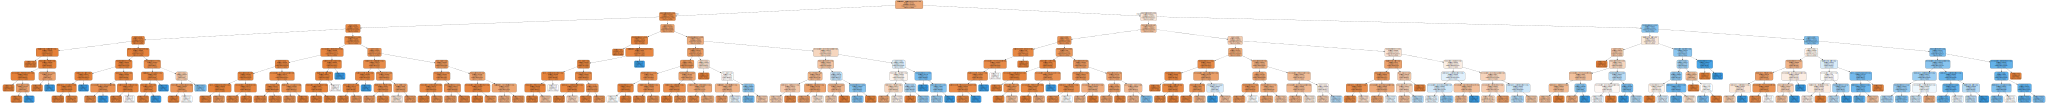

In [99]:
dot_data = export_graphviz(clf, out_file = None, feature_names = columns, class_names = classes, filled = True, rounded = True)
graph = graphviz.Source(dot_data)
graph

In [100]:
graph.render("tree_view")

'tree_view.pdf'

[Text(155.7904485049834, 205.35999999999999, 'X[29] <= 0.5\nentropy = 0.796\nsamples = 32561\nvalue = [24720, 7841]'),
 Text(70.87387873754153, 181.2, 'X[1] <= 12.5\nentropy = 0.348\nsamples = 17585\nvalue = [16436, 1149]'),
 Text(33.924916943521595, 157.04, 'X[0] <= 26.5\nentropy = 0.207\nsamples = 13987\nvalue = [13533, 454]'),
 Text(11.81810631229236, 132.88, 'X[0] <= 21.5\nentropy = 0.046\nsamples = 5452\nvalue = [5424, 28]'),
 Text(3.3368770764119606, 108.72, 'X[49] <= 0.5\nentropy = 0.008\nsamples = 3002\nvalue = [3000, 2]'),
 Text(2.2245847176079736, 84.56, 'entropy = 0.0\nsamples = 2510\nvalue = [2510, 0]'),
 Text(4.449169435215947, 84.56, 'X[16] <= 0.5\nentropy = 0.038\nsamples = 492\nvalue = [490, 2]'),
 Text(2.2245847176079736, 60.400000000000006, 'X[44] <= 0.5\nentropy = 0.021\nsamples = 487\nvalue = [486, 1]'),
 Text(1.1122923588039868, 36.24000000000001, 'entropy = 0.0\nsamples = 482\nvalue = [482, 0]'),
 Text(3.3368770764119606, 36.24000000000001, 'X[56] <= 0.5\nentropy 

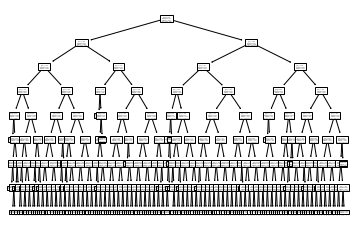

In [101]:

from sklearn import tree
tree.plot_tree(clf)